In [1]:
# import libraries
!pip install plotly xgboost imblearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix 
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import AdaBoostClassifier


# For reproducible results
RANDOM_STATE_SEED = 420

In [2]:
d1 = pd.read_csv("02-14-2018.csv")
d2 = pd.read_csv("02-15-2018.csv")
d3 = pd.read_csv("02-16-2018.csv")
d4 = pd.read_csv("02-21-2018.csv")
d7 = pd.read_csv("03-02-2018.csv")

In [3]:
d1['Timestamp']=pd.to_datetime(d1["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d2["Timestamp"]=pd.to_datetime(d2["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d3["Timestamp"]=pd.to_datetime(d3["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d4["Timestamp"]=pd.to_datetime(d4["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d7["Timestamp"]=pd.to_datetime(d7["Timestamp"], format = "%d/%m/%Y %H:%M:%S")

In [4]:
data=pd.concat([d1,d2,d3,d4,d7],axis=0)
data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0.0,2018-02-14 08:31:01,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,Benign
1,0,0.0,2018-02-14 08:33:50,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,Benign
2,0,0.0,2018-02-14 08:36:39,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,Benign
3,22,6.0,2018-02-14 08:40:13,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,22,6.0,2018-02-14 08:40:23,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88637,53,17.0,2018-03-02 09:51:29,1217.0,1.0,1.0,30.0,78.0,30.0,30.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
88638,3389,6.0,2018-03-02 03:40:51,1711199.0,8.0,7.0,1144.0,1581.0,677.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
88639,445,6.0,2018-03-02 10:55:55,543763.0,7.0,4.0,286.0,170.0,103.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
88640,53,17.0,2018-03-02 08:59:29,411.0,1.0,1.0,42.0,58.0,42.0,42.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 491017 entries, 0 to 88641
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Dst Port           491017 non-null  int64         
 1   Protocol           491016 non-null  float64       
 2   Timestamp          491016 non-null  datetime64[ns]
 3   Flow Duration      491016 non-null  float64       
 4   Tot Fwd Pkts       491016 non-null  float64       
 5   Tot Bwd Pkts       491016 non-null  float64       
 6   TotLen Fwd Pkts    491016 non-null  float64       
 7   TotLen Bwd Pkts    491016 non-null  float64       
 8   Fwd Pkt Len Max    491016 non-null  float64       
 9   Fwd Pkt Len Min    491016 non-null  float64       
 10  Fwd Pkt Len Mean   491016 non-null  float64       
 11  Fwd Pkt Len Std    491016 non-null  float64       
 12  Bwd Pkt Len Max    491016 non-null  float64       
 13  Bwd Pkt Len Min    491016 non-null  float64  

In [6]:
# Data shape
print('train data:',data.shape)

train data: (491017, 80)


In [7]:
data.head(10)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0.0,2018-02-14 08:31:01,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,Benign
1,0,0.0,2018-02-14 08:33:50,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,Benign
2,0,0.0,2018-02-14 08:36:39,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,Benign
3,22,6.0,2018-02-14 08:40:13,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,22,6.0,2018-02-14 08:40:23,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
5,22,6.0,2018-02-14 08:40:31,6989341.0,16.0,12.0,1239.0,2273.0,744.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
6,0,0.0,2018-02-14 08:39:28,112640480.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320240.0,203.646753,56320384.0,56320096.0,Benign
7,0,0.0,2018-02-14 08:42:17,112641244.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320622.0,62.225397,56320666.0,56320578.0,Benign
8,80,6.0,2018-02-14 08:47:14,476513.0,5.0,3.0,211.0,463.0,211.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
9,80,6.0,2018-02-14 08:47:15,475048.0,5.0,3.0,220.0,472.0,220.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


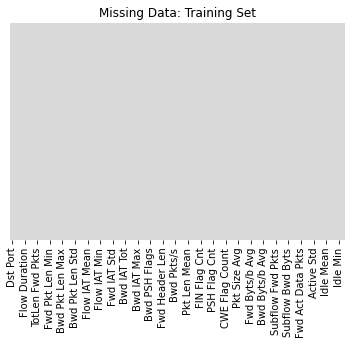

<Figure size 1440x720 with 0 Axes>

In [8]:
# Heatmap
sns.heatmap(data.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data: Training Set')
plt.figure(figsize=(20,10))
plt.show()

In [9]:
# attack Count
print('Target Variable')
print(data.groupby(['Label']).count())

Target Variable
                          Dst Port  Protocol  Timestamp  Flow Duration  \
Label                                                                    
Benign                       41195     41195      41195          41195   
Bot                          72079     72079      72079          72079   
DDOS attack-HOIC             85467     85467      85467          85467   
DDOS attack-LOIC-UDP          1730      1730       1730           1730   
DoS attacks-GoldenEye        41508     41508      41508          41508   
DoS attacks-Hulk             18501     18501      18501          18501   
DoS attacks-SlowHTTPTest     91434     91434      91434          91434   
DoS attacks-Slowloris        10990     10990      10990          10990   
FTP-BruteForce              128108    128108     128108         128108   

                          Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
Label                                                                   
Benign                 

In [10]:
# check the number of values for labels
data['Label'].value_counts()

FTP-BruteForce              128108
DoS attacks-SlowHTTPTest     91434
DDOS attack-HOIC             85467
Bot                          72079
DoS attacks-GoldenEye        41508
Benign                       41195
DoS attacks-Hulk             18501
DoS attacks-Slowloris        10990
DDOS attack-LOIC-UDP          1730
Name: Label, dtype: int64

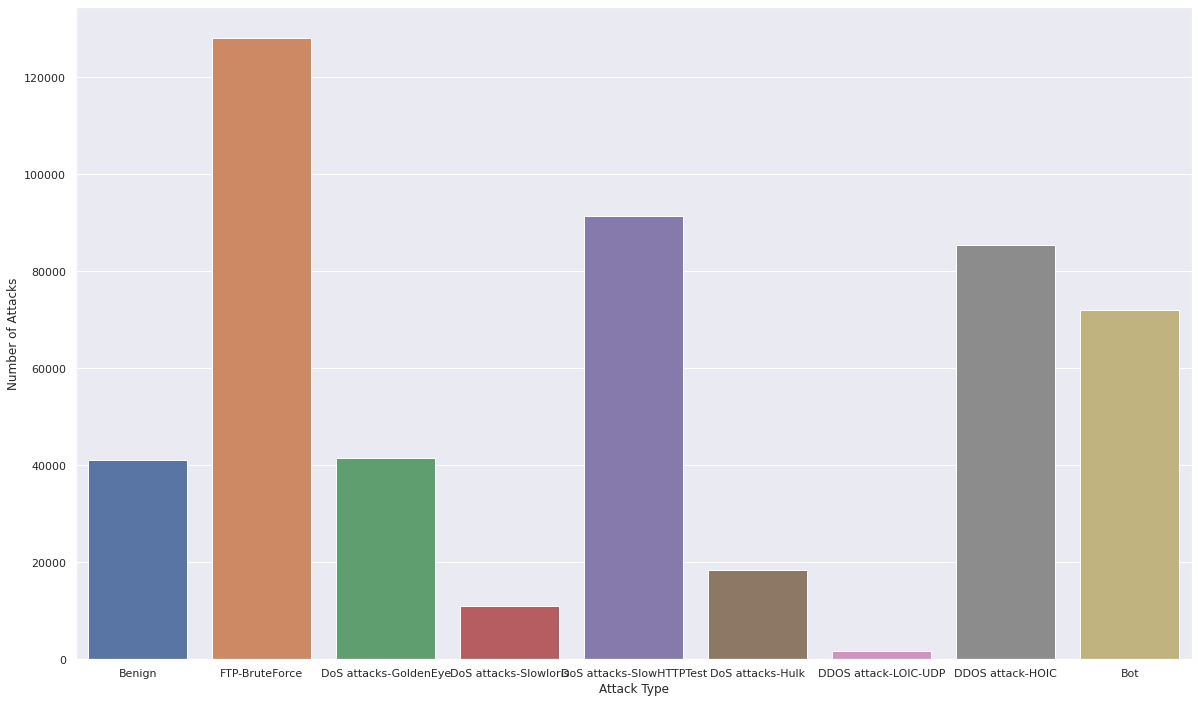

In [11]:
# make a plot number of labels
sns.set(rc={'figure.figsize':(20, 12)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

In [12]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [13]:
data.shape

(312111, 80)

In [14]:
data["Label"].value_counts()

DDOS attack-HOIC            84607
Bot                         71756
DoS attacks-GoldenEye       41455
Benign                      41039
FTP-BruteForce              26043
DoS attacks-SlowHTTPTest    19462
DoS attacks-Hulk            15734
DoS attacks-Slowloris       10285
DDOS attack-LOIC-UDP         1730
Name: Label, dtype: int64

In [15]:
data["Protocol"].unique()

array([ 0.,  6., 17.])

In [16]:
# Forcing them to be strings
data = data.astype({"Protocol": str})

In [17]:
data = pd.get_dummies(data, columns=['Protocol'], drop_first=True)

In [18]:
columns_to_drop = [
    'Dst Port',
    'Timestamp',
    'Fwd PSH Flags',
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'Flow Byts/s',  # This field had np.inf values during training, as such was removed
    'Flow Pkts/s'  # This field had np.inf values during training, as such was removed
]

In [19]:
data.drop(columns=columns_to_drop, inplace=True)

In [20]:
encoding={'Benign':0, 'FTP-BruteForce':1,'DoS attacks-GoldenEye':2, 'DoS attacks-Slowloris':3,'DoS attacks-SlowHTTPTest':4, 'DoS attacks-Hulk':5,"DDOS attack-HOIC":6,"Bot":7,"DDOS attack-LOIC-UDP":8}

In [21]:
data['Label']=data['Label'].map(encoding)

In [22]:
data["Label"].unique()

array([0, 1, 2, 3, 4, 5, 8, 6, 7])

In [23]:
# making Label column the last column again
data.insert(len(data.columns)-1, 'Label', data.pop('Label'))
data

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17.0,Protocol_6.0,Label
0,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,0,0,0
1,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,0,0,0
2,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,0,0,0
3,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,82.600000,196.741237,976.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
4,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,81.642857,203.745545,976.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88636,42887.0,2.0,2.0,100.0,264.0,50.0,50.0,50.000000,0.000000,132.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0
88637,1217.0,1.0,1.0,30.0,78.0,30.0,30.0,30.000000,0.000000,78.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0
88638,1711199.0,8.0,7.0,1144.0,1581.0,677.0,0.0,143.000000,227.969923,1173.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
88639,543763.0,7.0,4.0,286.0,170.0,103.0,0.0,40.857143,51.141727,131.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0


In [24]:
x=data.drop(columns="Label")
y=data["Label"]

In [25]:
def fold_cross_validation(splits,model):
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    cross_val_accuracy = 0
    for fold, (tr_index , val_index) in enumerate(kf.split(data)):

        print("⁙" * 10)
        print(f"Fold {fold + 1}")

        x_train,x_val = x.values[tr_index] , x.values[val_index]
        y_train,y_val = y.values[tr_index] , y.values[val_index]

        model.fit(x_train, y_train)
        predictions = model.predict(x_val)
        print("accuracy score :",accuracy_score(y_val, predictions))
        cross_val_accuracy += accuracy_score(y_val, predictions)
        print(classification_report(y_val, predictions, digits=5))
        print("geometric mean score :",geometric_mean_score(y_val, predictions, average='weighted'))
        

    cross_val_accuracy /= 5

In [26]:
    decisiontree = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=19,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0)

In [27]:
fold_cross_validation(5,decisiontree)

⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1
accuracy score : 0.9557695080338977
              precision    recall  f1-score   support

           0    0.99876   0.99505   0.99690      8088
           1    0.70247   0.82379   0.75831      5153
           2    0.99820   0.99964   0.99892      8323
           3    0.99757   0.99757   0.99757      2055
           4    0.69760   0.53852   0.60783      3894
           5    0.99810   0.99937   0.99873      3155
           6    1.00000   1.00000   1.00000     17039
           7    0.99875   0.99958   0.99917     14381
           8    1.00000   1.00000   1.00000       335

    accuracy                        0.95577     62423
   macro avg    0.93238   0.92817   0.92860     62423
weighted avg    0.95571   0.95577   0.95470     62423

geometric mean score : 0.9758167798421503
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2
accuracy score : 0.9542949601102175
              precision    recall  f1-score   support

           0    0.99707   0.99561   0.99634      8202
           1    0.69654   0.82357   

In [28]:
randomforest = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)

In [29]:
fold_cross_validation(5,randomforest)

⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9558335869791583
              precision    recall  f1-score   support

           0    0.99827   0.99629   0.99728      8088
           1    0.70487   0.81525   0.75605      5153
           2    0.99964   1.00000   0.99982      8323
           3    0.99757   0.99854   0.99805      2055
           4    0.69139   0.54828   0.61157      3894
           5    0.99968   0.99937   0.99952      3155
           6    1.00000   0.99994   0.99997     17039
           7    0.99847   0.99930   0.99889     14381
           8    1.00000   1.00000   1.00000       335

    accuracy                        0.95583     62423
   macro avg    0.93221   0.92855   0.92902     62423
weighted avg    0.95566   0.95583   0.95490     62423

geometric mean score : 0.9758565616705619
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9545032200185832
              precision    recall  f1-score   support

           0    0.99756   0.99610   0.99683      8202
           1    0.69654   0.82357   0.75475      5209
           2    0.99988   1.00000   0.99994      8348
           3    0.99853   0.99805   0.99829      2048
           4    0.69690   0.53064   0.60251      3982
           5    0.99967   1.00000   0.99984      3074
           6    0.99953   0.99965   0.99959     16932
           7    0.99867   0.99930   0.99899     14298
           8    1.00000   1.00000   1.00000       329

    accuracy                        0.95450     62422
   macro avg    0.93192   0.92748   0.92786     62422
weighted avg    0.95451   0.95450   0.95334     62422

geometric mean score : 0.9750696756010586
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 3


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9555284995674602
              precision    recall  f1-score   support

           0    0.99758   0.99661   0.99709      8261
           1    0.69843   0.82930   0.75826      5161
           2    1.00000   0.99988   0.99994      8242
           3    0.99805   0.99756   0.99781      2052
           4    0.70044   0.52726   0.60164      3907
           5    1.00000   1.00000   1.00000      3183
           6    0.99964   0.99982   0.99973     16866
           7    0.99882   0.99924   0.99903     14390
           8    1.00000   1.00000   1.00000       360

    accuracy                        0.95553     62422
   macro avg    0.93255   0.92774   0.92817     62422
weighted avg    0.95556   0.95553   0.95432     62422

geometric mean score : 0.9756626701376016
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 4


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.956697959052898
              precision    recall  f1-score   support

           0    0.99794   0.99612   0.99703      8248
           1    0.71557   0.82671   0.76714      5286
           2    0.99988   0.99988   0.99988      8210
           3    0.99715   0.99857   0.99786      2102
           4    0.69477   0.54553   0.61117      3822
           5    1.00000   1.00000   1.00000      3160
           6    0.99982   0.99976   0.99979     16807
           7    0.99841   0.99931   0.99886     14453
           8    1.00000   1.00000   1.00000       334

    accuracy                        0.95670     62422
   macro avg    0.93373   0.92954   0.93019     62422
weighted avg    0.95642   0.95670   0.95567     62422

geometric mean score : 0.9762945406617336
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 5


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9559770593700939
              precision    recall  f1-score   support

           0    0.99805   0.99575   0.99690      8240
           1    0.71070   0.81716   0.76022      5234
           2    0.99988   1.00000   0.99994      8332
           3    0.99754   0.99901   0.99828      2028
           4    0.68846   0.54887   0.61079      3857
           5    0.99905   1.00000   0.99953      3162
           6    0.99994   0.99971   0.99982     16963
           7    0.99839   0.99937   0.99888     14234
           8    1.00000   1.00000   1.00000       372

    accuracy                        0.95598     62422
   macro avg    0.93245   0.92887   0.92937     62422
weighted avg    0.95571   0.95598   0.95504     62422

geometric mean score : 0.9759181013578776


In [30]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)





In [31]:
fold_cross_validation(5,xgboost)

⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1
accuracy score : 0.9555452317254858
              precision    recall  f1-score   support

           0    0.99864   0.99728   0.99796      8088
           1    0.69459   0.83505   0.75837      5153
           2    1.00000   1.00000   1.00000      8323
           3    0.99660   0.99903   0.99781      2055
           4    0.70196   0.51412   0.59354      3894
           5    0.99937   1.00000   0.99968      3155
           6    0.99994   1.00000   0.99997     17039
           7    0.99917   0.99937   0.99927     14381
           8    1.00000   1.00000   1.00000       335

    accuracy                        0.95555     62423
   macro avg    0.93225   0.92721   0.92740     62423
weighted avg    0.95567   0.95555   0.95417     62423

geometric mean score : 0.9756959426059076
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2
accuracy score : 0.9548236198776072
              precision    recall  f1-score   support

           0    0.99890   0.99732   0.99811      8202
           1    0.69654   0.82357   

In [32]:
adaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                              learning_rate=0.1,
                              n_estimators=100)

In [33]:
fold_cross_validation(5,adaBoost)

⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1
accuracy score : 0.3336270284991109
              precision    recall  f1-score   support

           0    0.16861   0.95166   0.28646      8088
           1    0.62939   0.89676   0.73966      5153
           2    0.99982   0.68521   0.81315      8323
           3    0.00000   0.00000   0.00000      2055
           4    0.68798   0.30123   0.41900      3894
           5    1.00000   0.40856   0.58011      3155
           6    0.00000   0.00000   0.00000     17039
           7    0.02010   0.00056   0.00108     14381
           8    1.00000   1.00000   1.00000       335

    accuracy                        0.33363     62423
   macro avg    0.50066   0.47155   0.42661     62423
weighted avg    0.31057   0.33363   0.26767     62423

geometric mean score : 0.5489174152431189
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy score : 0.41591105699913494
              precision    recall  f1-score   support

           0    0.19841   0.99927   0.33108      8202
           1    0.62927   0.89576   0.73923      5209
           2    0.99277   0.90465   0.94666      8348
           3    1.00000   0.46973   0.63920      2048
           4    0.69426   0.30964   0.42827      3982
           5    0.99967   0.98373   0.99164      3074
           6    0.00000   0.00000   0.00000     16932
           7    0.00000   0.00000   0.00000     14298
           8    1.00000   1.00000   1.00000       329

    accuracy                        0.41591     62422
   macro avg    0.61271   0.61809   0.56401     62422
weighted avg    0.34295   0.41591   0.33419     62422

geometric mean score : 0.6169003013525717
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 3


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy score : 0.3907436480727948
              precision    recall  f1-score   support

           0    0.18814   0.96744   0.31502      8261
           1    0.63156   0.89944   0.74207      5161
           2    0.99208   0.89675   0.94201      8242
           3    1.00000   0.01365   0.02692      2052
           4    0.69790   0.30689   0.42631      3907
           5    1.00000   0.98492   0.99240      3183
           6    0.00000   0.00000   0.00000     16866
           7    0.01527   0.00028   0.00055     14390
           8    0.00000   0.00000   0.00000       360

    accuracy                        0.39074     62422
   macro avg    0.50277   0.45215   0.38281     62422
weighted avg    0.33917   0.39074   0.30572     62422

geometric mean score : 0.5962647085891457
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 4


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy score : 0.4673993143443017
              precision    recall  f1-score   support

           0    0.21584   1.00000   0.35505      8248
           1    0.64540   0.84185   0.73065      5286
           2    1.00000   0.57710   0.73185      8210
           3    1.00000   0.25833   0.41059      2102
           4    0.62223   0.36028   0.45634      3822
           5    1.00000   0.37373   0.54411      3160
           6    1.00000   0.49414   0.66144     16807
           7    0.00000   0.00000   0.00000     14453
           8    1.00000   1.00000   1.00000       334

    accuracy                        0.46740     62422
   macro avg    0.72039   0.54505   0.54334     62422
weighted avg    0.61169   0.46740   0.45780     62422

geometric mean score : 0.6566101919210888
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 5


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy score : 0.4172407164140848
              precision    recall  f1-score   support

           0    0.19913   0.99769   0.33199      8240
           1    0.63166   0.89740   0.74144      5234
           2    0.99523   0.90110   0.94583      8332
           3    1.00000   0.48669   0.65473      2028
           4    0.67553   0.28986   0.40566      3857
           5    0.99968   0.99462   0.99715      3162
           6    0.00000   0.00000   0.00000     16963
           7    0.00000   0.00000   0.00000     14234
           8    1.00000   0.99194   0.99595       372

    accuracy                        0.41724     62422
   macro avg    0.61125   0.61770   0.56364     62422
weighted avg    0.34292   0.41724   0.33502     62422

geometric mean score : 0.6178031061433671


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [34]:
import pickle
xgb_file_name = "xgb_multi.pkl"
rf_file_name = "randomforest_multi.pkl"
decisiontree_file="DecisionTree_multi.pkl"
adaboost_file="adaboost_multi.pkl"
# save
pickle.dump(xgboost, open(xgb_file_name, "wb"))
pickle.dump(randomforest, open(rf_file_name, "wb"))
pickle.dump(decisiontree, open(decisiontree_file, "wb"))
pickle.dump(adaBoost, open(adaboost_file, "wb"))

In [37]:
data

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17.0,Protocol_6.0,Label
0,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,0,0,0
1,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,0,0,0
2,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,0,0,0
3,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,82.600000,196.741237,976.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
4,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,81.642857,203.745545,976.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88636,42887.0,2.0,2.0,100.0,264.0,50.0,50.0,50.000000,0.000000,132.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0
88637,1217.0,1.0,1.0,30.0,78.0,30.0,30.0,30.000000,0.000000,78.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0
88638,1711199.0,8.0,7.0,1144.0,1581.0,677.0,0.0,143.000000,227.969923,1173.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
88639,543763.0,7.0,4.0,286.0,170.0,103.0,0.0,40.857143,51.141727,131.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
